### Dictdiffer is a helper module that helps you to diff and patch dictionaries.
### ! pip install dictdiffer # Remove the comment character "#" first time 

In [6]:
pip install dictdiffer

Note: you may need to restart the kernel to use updated packages.


In [22]:
df = pd.read_csv("Health.csv")
df.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [27]:
a = df["Health Indicator"].value_counts()/len(df)*100
proportions = df['Health Indicator'].value_counts(normalize=True)
probabilities = proportions.values
df["Health Indicator"].fillna(pd.Series(np.random.choice(["X1","X2","X3","X4","X5","X6","X7","X8","X9"],p = probabilities,size = len(df))),inplace = True)

In [29]:
df["Holding_Policy_Duration"].replace("14+", 14.0, inplace=True)
df["Holding_Policy_Duration"] = pd.to_numeric(df["Holding_Policy_Duration"])
proportions = df['Holding_Policy_Duration'].value_counts(normalize=True)
probabilities = proportions.values
df["Holding_Policy_Duration"].fillna(pd.Series(np.random.choice([1.0, 14.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 0.0, 13.0], p=probabilities, size=len(df))), inplace=True)

In [30]:
c = df['Holding_Policy_Type'].value_counts()/len(df)*100
proportions = df['Holding_Policy_Type'].value_counts(normalize=True)
probabilities = proportions.values
df["Holding_Policy_Type"].fillna(pd.Series(np.random.choice([3.0,1.0,2.0,4.0],p = probabilities,size = len(df))),inplace = True)

In [31]:
### Files related to data before applying SMOTE
file_X_train_Orig  = 'X_train_wo_SMOTE.csv'
file_y_train_Orig  = 'y_train_wo_SMOTE.csv'
file_X_test_Orig   = 'X_test_wo_SMOTE.csv'
file_y_test_Orig   = 'y_test_wo_SMOTE.csv'
### Files related to data after applying SMOTE
file_X_train_SMOTE = 'X_train_SMOTE.csv'
file_y_train_SMOTE = 'y_train_SMOTE.csv'

In [32]:
import   pandas                   as      pd
import   numpy                    as      np
import   matplotlib.pyplot        as      plt

In [52]:
from   sklearn.svm                import    SVC
from   sklearn.ensemble           import    RandomForestClassifier
from   sklearn.model_selection    import    StratifiedKFold
from   sklearn.model_selection    import    RandomizedSearchCV
from   sklearn.model_selection    import    train_test_split

In [34]:
from    sklearn.linear_model    import  LogisticRegression
from    sklearn.tree            import  DecisionTreeClassifier
from    sklearn.neighbors       import  KNeighborsClassifier
from    sklearn.naive_bayes     import  GaussianNB
from    sklearn.ensemble        import  RandomForestClassifier    
from    xgboost                 import  XGBClassifier  
from    sklearn.ensemble        import  AdaBoostClassifier

In [35]:
from   sklearn.metrics            import  make_scorer, precision_score, recall_score, f1_score
from   sklearn.metrics            import  confusion_matrix, classification_report

In [36]:
from dictdiffer import diff, patch, swap, revert

In [102]:
performance_hyper_df       =    pd.DataFrame()

In [88]:
'''
We need to know what changed after getting the best parameters by performing hyper parameter tuning,
'''
def  what_changed(first_dict, second_dict):
       result = diff(first_dict, second_dict)
       return list(result)


In [89]:
def  metrics_graph(df, model_names):
     print(df.columns)
     scores_req   =   ['roc_auc', 'precision', 'recall', 'F1 Weighted']
     for       scoring in   scores_req :
               df1      =  df.loc[df['Score'] == scoring, ['Name', 'Results']]
               df1.plot.box(column = "Results", by = "Name", figsize=(8, 6), grid=False, rot=90, fontsize = 15)
               txt      =  "Model performance using " + scoring
               plt.title(txt)
               plt.show()


In [90]:
def evaluate_model_performance(model, name, X, y):
    from  sklearn.model_selection import  StratifiedKFold
    from  sklearn.model_selection import  cross_val_score

    # Predict the response for training dataset
    classifier   =  model.fit(X, y)
    scores_req   =  ['roc_auc', 'precision', 'recall', 'F1 Weighted']
    df_model     =  pd.DataFrame()
    for scoring in scores_req:
        score_fn  =  scoring         

        print("\nPerformance Measure : %s" %scoring)

        if scoring == 'F1 Weighted':
            score_fn  =  make_scorer (f1_score, average = 'weighted', zero_division = 0)

        skf           =   StratifiedKFold(n_splits = 10, shuffle = True, random_state = 12345)
        cv_results    =   cross_val_score(model, X, np.ravel(y,order="c"), cv = skf, scoring = score_fn)
        msg = "%s" % (str(round(cv_results.mean(),2)) + " ± " + str(round(cv_results.std(),2)))
        print(msg)
        df_measures_tuned.at[name, scoring] = round(cv_results.mean(),2)
        indices_      =   list(range(1, 11))
        df_ind        =   pd.DataFrame({'Score' : scoring, 'Name' : name, 'Resuts' : cv_results,\
                                        'Mean-Sd' : msg}, index = indices_)
        df_model      =   pd.concat([df_model, df_ind]) 
    return df_model

In [91]:
def get_default(model, X, y):
    model.fit(X, np.ravel(y,order="c"))
    print(model.get_params())

In [92]:
def draw_cm( actual, predicted ):
    
    import matplotlib.pyplot as   plt
    import sklearn.metrics   as   metrics
    import seaborn           as   sns
    
    cm = metrics.confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels = ["Yes", "No"] , yticklabels = ["Yes", "No"] )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()  

In [93]:
def draw_roc( actual, probs ):

    import pandas            as   pd
    import numpy             as   np
    import seaborn           as   sns
    import matplotlib.pyplot as   plt
    import sklearn.metrics   as   metrics
    import seaborn           as   sns
    

    
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
    drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 4))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()
    return fpr, tpr, thresholds

In [94]:
def tune_hyperparameters(model, name, X, y, grid_values):
    scoring  =  {'recall': make_scorer(recall_score, average = 'binary')}

    grid_search_model = RandomizedSearchCV(estimator = model, param_distributions = grid_values, 
                                          scoring = scoring, refit = 'recall',random_state = 1234)
    
    grid_result       = grid_search_model.fit(X, np.ravel(y, order = "c"))
    # grid_search_model.cv_results_
    print("\nBest_params: {}".format(grid_search_model.best_params_)) 
    print("\nCV Results: {}".format(grid_search_model.cv_results_['mean_test_recall']))
    ###      
    thisdict = { "Model" :name, "Best Recall": grid_result.best_score_, "Params" : grid_result.best_params_} 
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    res_df                 =    pd.DataFrame(thisdict)
    return res_df

In [95]:
def compare_models(n_splits, random_state, X, y):  

    ### To compare algorithms
    
    from    matplotlib              import  pyplot
    from    sklearn.model_selection import  StratifiedKFold
    from    sklearn.model_selection import  cross_val_score
    from    sklearn.linear_model    import  LogisticRegression
    from    sklearn.tree            import  DecisionTreeClassifier
    from    sklearn.neighbors       import  KNeighborsClassifier
    from    sklearn.naive_bayes     import  GaussianNB
    from    sklearn.ensemble        import  RandomForestClassifier    
    from    xgboost                 import  XGBClassifier  
    from    sklearn.ensemble        import  AdaBoostClassifier
 
    from    sklearn.metrics         import  make_scorer, f1_score
    ### Prepare models
    
    models  = []
    models.append(('LR', LogisticRegression(max_iter = 3000)))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('XGBoost',XGBClassifier()))
    models.append(('AdaBoost',AdaBoostClassifier()))    
   
    model = () 
    
    
    ### Evaluate model in turn
    
    print("\n n_splits %d random_state %d" % (n_splits, random_state)) 
    
    scores_req  =  ['roc_auc', 'precision', 'recall', 'F1 Weighted']
    
    for i in range(len(scores_req)):
        results   =  []  
        names     =  []
        scoring   =  scores_req[i]
        print("\nPerformance Measure : %s" %scoring)
        score_fn  =  scoring 
        if scoring == 'F1 Weighted':
           score_fn  =  make_scorer (f1_score, average = 'weighted', zero_division = 0)
        
        for name, model in models:
       	    print(name, model)
            skf           =   StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 12345)
            cv_results    =   cross_val_score(model, X, np.ravel(y,order="c"), cv = skf, scoring = score_fn)
        
            results.append(cv_results) 
            names.append(name)
            msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
            print(msg)
            df_measures_untuned.at[name, scoring] = round(cv_results.mean(),2)
        ### Box plot algorithm comparison
        
        sub_title = 'Algorithm Comparison using ' + scoring.upper()
        
        fig = pyplot.figure()
        fig.suptitle(sub_title)
        ax  = fig.add_subplot(111)
        pyplot.boxplot(results)
        ax.set_xticklabels(names)
        pyplot.show()

### ---------------------------------------------------------------------------

In [96]:
def evaluate_model_SM_performance(name, model, x_train, y_train, x_test, y_test):
    from sklearn.metrics import recall_score, precision_score,roc_auc_score,f1_score  
    # Predict the response for training dataset
    classifier         =  model.fit(x_train, y_train)
    # print the model parameters
    print("Model parameters: {}".format(model.get_params()))
    predicted_train    =  classifier.predict(x_train)
    matrix             =  confusion_matrix(y_train, predicted_train)
    ###
    train_auroc        =  roc_auc_score(y_train, predicted_train)
    train_recall       =  recall_score(y_train, predicted_train)
    train_precision    =  precision_score(y_train, predicted_train)
    train_f1score      =  f1_score(y_train, predicted_train, average = 'weighted')
    ###
    print("\nTraining Data")
    print(matrix)
    draw_cm(y_train, predicted_train)
    measures_train      = classification_report(y_train, predicted_train) 
    print("\nTraining Data")
    print(measures_train) 
    draw_roc(y_train, predicted_train)
    # Predict the response for testing dataset
    predicted_test     =  classifier.predict(x_test)
    matrix1            =  confusion_matrix(y_test, predicted_test)
    ### 
    test_auroc         =  roc_auc_score(y_test, predicted_test)
    test_recall        =  recall_score(y_test, predicted_test)
    test_precision     =  precision_score(y_test, predicted_test)
    test_f1score       =  f1_score(y_test, predicted_test, average = 'weighted')
    ###    
    print("\nTest  Data")
    print(matrix1)
    draw_cm(y_test, predicted_test)
    measures_test     = classification_report(y_test, predicted_test) 
    print("\nTest  Data")
    print(measures_test) 
    draw_roc(y_test, predicted_test) 
    df_smote  =  pd.DataFrame({'Model' : name, 'Recall Training data' : train_recall, 'Recall Test data' : test_recall,\
                              'F1 Weighted Training data' : train_f1score, 'F1 Weighted Test data' : test_f1score,
                              'AUROC Training data' : train_auroc, 'AUROC Test data' : test_auroc,
                              'Precision Training data' : train_precision, 'Precision Test data' : test_precision},\
                              index = [0]) 
    return df_smote

In [97]:
df1_0    =   pd.DataFrame({'Model' : 'LR', 'roc_auc' : 0, 'precision' : 0, 'recall' : 0, 'F1 Weighted' :0}, index = [0])
df1_0.reset_index()
dict = {'Model' : 'KNN', 'roc_auc' : 0, 'precision' : 0, 'recall' : 0, 'F1 Weighted' :0}
df12 = pd.DataFrame(dict, index = [0])
#
dict = {'Model' : 'CART', 'roc_auc' : 0, 'precision' : 0, 'recall' : 0, 'F1 Weighted' :0}
df13 = pd.DataFrame(dict, index = [0])
#
dict = {'Model' : 'NB', 'roc_auc' : 0, 'precision' : 0, 'recall' : 0, 'F1 Weighted' :0}
df14  = pd.DataFrame(dict, index = [0])
#
dict = {'Model' : 'RF', 'roc_auc' : 0, 'precision' : 0, 'recall' : 0, 'F1 Weighted' :0}
df15  = pd.DataFrame(dict, index = [0])
#
dict = {'Model' : 'XGBoost', 'roc_auc' : 0, 'precision' : 0, 'recall' : 0, 'F1 Weighted' :0}
df16  = pd.DataFrame(dict, index = [0])
#
dict = {'Model' : 'AdaBoost', 'roc_auc' : 0, 'precision' : 0, 'recall' : 0, 'F1 Weighted' :0}
df17  = pd.DataFrame(dict, index = [0])
##
df17_ = pd.concat([df1_0, df12, df13, df14, df15, df16, df17], ignore_index = True)
#

df_measures_untuned  =  df17_.copy()
df_measures_untuned.set_index(['Model'], inplace = True)
print(df_measures_untuned)

          roc_auc  precision  recall  F1 Weighted
Model                                            
LR              0          0       0            0
KNN             0          0       0            0
CART            0          0       0            0
NB              0          0       0            0
RF              0          0       0            0
XGBoost         0          0       0            0
AdaBoost        0          0       0            0


In [98]:
df_0    =   pd.DataFrame({'Model' : 'LR', 'roc_auc' : 0, 'precision' : 0, 'recall' : 0, 'F1 Weighted' :0}, index = [0])
df_0.reset_index()
dict = {'Model' : 'KNN', 'roc_auc' : 0, 'precision' : 0, 'recall' : 0, 'F1 Weighted' :0}
df2 = pd.DataFrame(dict, index = [0])
#
dict = {'Model' : 'CART', 'roc_auc' : 0, 'precision' : 0, 'recall' : 0, 'F1 Weighted' :0}
df3 = pd.DataFrame(dict, index = [0])
#
dict = {'Model' : 'NB', 'roc_auc' : 0, 'precision' : 0, 'recall' : 0, 'F1 Weighted' :0}
df4  = pd.DataFrame(dict, index = [0])
#
dict = {'Model' : 'RF', 'roc_auc' : 0, 'precision' : 0, 'recall' : 0, 'F1 Weighted' :0}
df5  = pd.DataFrame(dict, index = [0])
#
dict = {'Model' : 'XGBoost', 'roc_auc' : 0, 'precision' : 0, 'recall' : 0, 'F1 Weighted' :0}
df6  = pd.DataFrame(dict, index = [0])
#
dict = {'Model' : 'AdaBoost', 'roc_auc' : 0, 'precision' : 0, 'recall' : 0, 'F1 Weighted' :0}
df7  = pd.DataFrame(dict, index = [0])
##
df7_ = pd.concat([df_0, df2, df3, df4, df5, df6, df7], ignore_index = True)
#

df_measures_tuned  =  df7_.copy()
df_measures_tuned.set_index(['Model'], inplace = True)
print(df_measures_tuned)

          roc_auc  precision  recall  F1 Weighted
Model                                            
LR              0          0       0            0
KNN             0          0       0            0
CART            0          0       0            0
NB              0          0       0            0
RF              0          0       0            0
XGBoost         0          0       0            0
AdaBoost        0          0       0            0


### Load the Dataset

In [58]:
X = df.drop(columns= ["ID","Response"],axis = 1)
y = df["Response"]
X_train,X_test,y_train,y_test = train_test_split(x,y,train_size = 0.8, test_size = 0.2, random_state =3, stratify = y)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(40705, 12) (10177, 12) (40705,) (10177,)


In [59]:
print("\n Shape of X_train {}".format(X_train.shape))
print("\n Shape of X_test {}".format(X_test.shape))
print("\n Shape of y_train {}".format(y_train.shape))
print("\n Shape of y_test {}".format(y_test.shape))


 Shape of X_train (40705, 12)

 Shape of X_test (10177, 12)

 Shape of y_train (40705,)

 Shape of y_test (10177,)


In [63]:
X_train["City_Code"].value_counts()
geo_encoding = X_train["City_Code"].value_counts().to_dict()
X_train["City_Code"]=X_train["City_Code"].map(geo_encoding)
X_test["City_Code"]=X_test["City_Code"].map(geo_encoding)
X_train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
30990,744,1640,Rented,Individual,35,35,No,X3,4.0,3.0,13,9120.0
3610,1512,127,Rented,Joint,62,49,Yes,X5,1.0,1.0,1,26376.0
32674,3912,409,Rented,Individual,27,27,No,X4,3.0,4.0,19,11916.0
3685,948,4301,Owned,Individual,56,56,No,X6,1.0,2.0,1,13260.0
19142,6176,2162,Rented,Individual,40,40,No,X1,9.0,2.0,13,12906.0


In [67]:
X_train["Health Indicator"].value_counts()
health_encoding = X_train["Health Indicator"].value_counts().to_dict()
X_train["Health Indicator"]=X_train["Health Indicator"].map(health_encoding)
X_test["Health Indicator"]=X_test["Health Indicator"].map(health_encoding)
X_train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
30990,744,1640,Rented,Individual,35,35,No,7098,4.0,3.0,13,9120.0
3610,1512,127,Rented,Joint,62,49,Yes,1829,1.0,1.0,1,26376.0
32674,3912,409,Rented,Individual,27,27,No,5950,3.0,4.0,19,11916.0
3685,948,4301,Owned,Individual,56,56,No,1353,1.0,2.0,1,13260.0
19142,6176,2162,Rented,Individual,40,40,No,13501,9.0,2.0,13,12906.0


In [72]:
# Dummy encoding for Accomodation_type,Reco_Insurance_Type
X_train = pd.get_dummies(X_train,drop_first = True,dtype = int,columns=["Accomodation_Type","Reco_Insurance_Type","Is_Spouse"])
X_test = pd.get_dummies(X_test,drop_first=True, dtype = int,columns=["Accomodation_Type","Reco_Insurance_Type","Is_Spouse"])

In [73]:
X_train.columns
X_train = X_train.rename(columns={"Accomodation_Type_Rented":"Accomodation_Type","Reco_Insurance_Type_Joint":"Reco_Insurance_Type","Is_Spouse_Yes":"Is_Spouse"})

In [75]:
X_test  = X_test.rename(columns={"Accomodation_Type_Rented":"Accomodation_Type","Reco_Insurance_Type_Joint":"Reco_Insurance_Type","Is_Spouse_Yes":"Is_Spouse"})

## Merge train and test dataframes for doing KFold cross-validation that is superior to train & test evaluation

In [76]:
### Merge train and test datasets for X 
frames_train = [X_train, X_test]
X            = pd.concat(frames_train )
print("\n Shape of X {}".format(X.shape))


 Shape of X (50882, 12)


In [77]:
### Merge test and test datasets for y 
frames_test = [y_train, y_test]
y            = pd.concat(frames_test)
print("\n Shape of y {}".format(y.shape))


 Shape of y (50882,)


n_splits      =  10
random_state  =  12345
compare_models_not_tuned(n_splits, random_state, X, y)  


 n_splits 10 random_state 12345

Performance Measure : roc_auc
LR LogisticRegression(max_iter=3000)


C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

LR: 0.552514 (0.010569)
KNN KNeighborsClassifier()
KNN: 0.503620 (0.010924)
CART DecisionTreeClassifier()
CART: 0.548932 (0.007963)
NB GaussianNB()
NB: 0.554976 (0.006627)
RF RandomForestClassifier()
RF: 0.616019 (0.009230)
XGBoost XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
XGBoost: 0

C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME alg

AdaBoost: 0.614617 (0.009589)


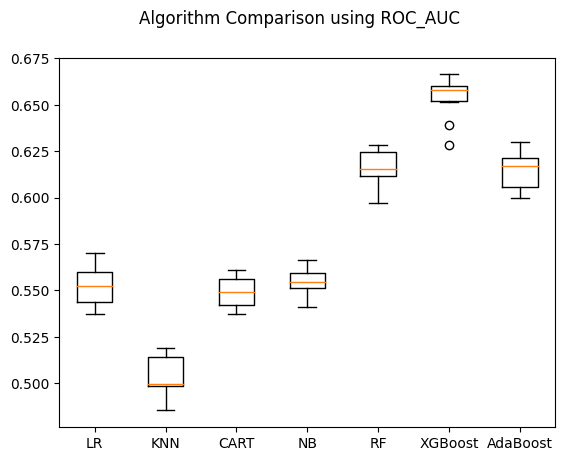


Performance Measure : precision
LR LogisticRegression(max_iter=3000)


C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge

LR: 0.000000 (0.000000)
KNN KNeighborsClassifier()
KNN: 0.239691 (0.022224)
CART DecisionTreeClassifier()


C:\Users\SAI SWAROOP\AppData\Local\Temp\ipykernel_24392\1366150473.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.24' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_measures_untuned.at[name, scoring] = round(cv_results.mean(),2)


CART: 0.310489 (0.008242)
NB GaussianNB()


C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWA

NB: 0.000000 (0.000000)
RF RandomForestClassifier()
RF: 0.415633 (0.044452)
XGBoost XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
XGBoost: 0.466044 (0.039115)
AdaBoost AdaBoostClassifier()


C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the def

AdaBoost: 0.350000 (0.450000)


C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


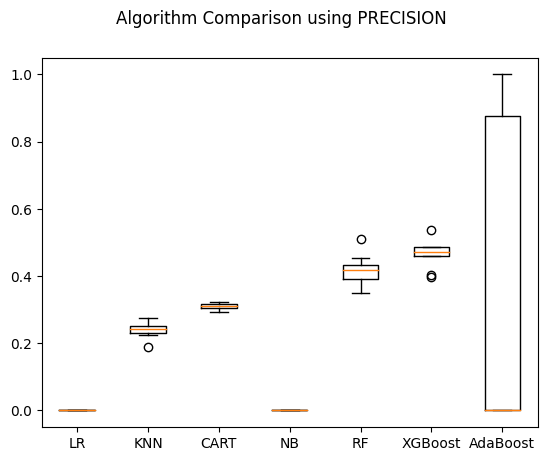


Performance Measure : recall
LR LogisticRegression(max_iter=3000)


C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

LR: 0.000000 (0.000000)
KNN KNeighborsClassifier()
KNN: 0.093455 (0.011437)
CART DecisionTreeClassifier()


C:\Users\SAI SWAROOP\AppData\Local\Temp\ipykernel_24392\1366150473.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.09' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_measures_untuned.at[name, scoring] = round(cv_results.mean(),2)


CART: 0.326726 (0.009529)
NB GaussianNB()
NB: 0.000000 (0.000000)
RF RandomForestClassifier()
RF: 0.025555 (0.003317)
XGBoost XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
XGBoost: 0.073305 (0.008599)
AdaBoost AdaBoostClassifier()


C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME alg

AdaBoost: 0.000410 (0.000549)


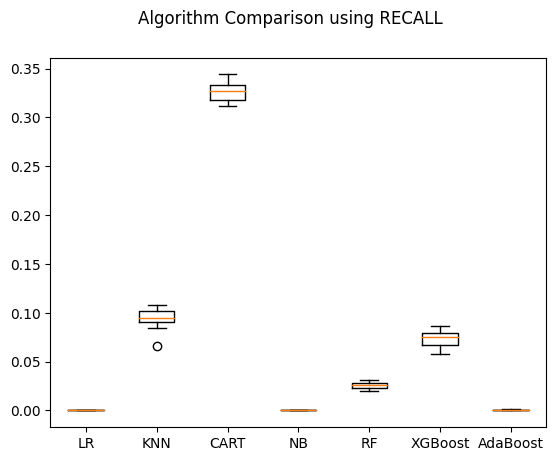


Performance Measure : F1 Weighted
LR LogisticRegression(max_iter=3000)


C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

LR: 0.656435 (0.000080)
KNN KNeighborsClassifier()
KNN: 0.660771 (0.004564)
CART DecisionTreeClassifier()
CART: 0.668791 (0.005081)
NB GaussianNB()
NB: 0.656435 (0.000080)
RF RandomForestClassifier()
RF: 0.665931 (0.003527)
XGBoost XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
XGBoost: 0

C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME alg

AdaBoost: 0.656629 (0.000320)


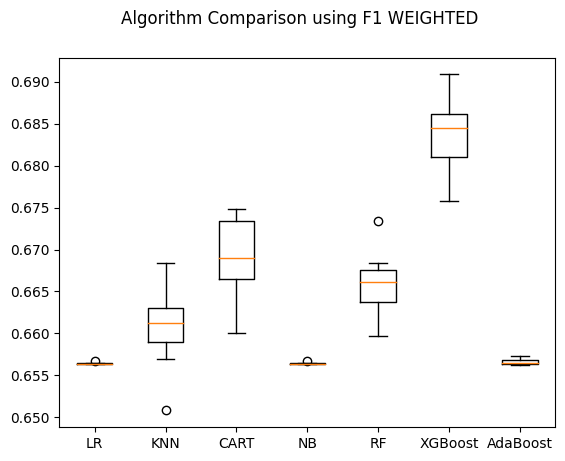

In [78]:
n_splits      =  10
random_state  =  12345
compare_models(n_splits, random_state, X, y)

In [79]:
df_measures_untuned.sort_values(by=['recall'], ascending = False)

,roc_auc,precision,recall,F1 Weighted
Model,,,,
CART,0.55,0.31,0.33,0.67
KNN,0.50,0.24,0.09,0.66
XGBoost,0.65,0.47,0.07,0.68
RF,0.62,0.42,0.03,0.67
LR,0.55,0.00,0.00,0.66
NB,0.55,0.00,0.00,0.66
AdaBoost,0.61,0.35,0.00,0.66


## Hyper parameter tuning for all the models

## Get the default parameters for all the models

In [80]:
Models   =  [LogisticRegression(), DecisionTreeClassifier(),  KNeighborsClassifier(), GaussianNB(),\
             RandomForestClassifier(), XGBClassifier (), AdaBoostClassifier()]

In [103]:
for model in Models:
    print("\n{}\n".format(model))
    get_default(model, X, y)


LogisticRegression()



C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

DecisionTreeClassifier()

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}

KNeighborsClassifier()

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

GaussianNB()

{'priors': None, 'var_smoothing': 1e-09}

RandomForestClassifier()

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nod

C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'algorithm': 'SAMME.R', 'estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}


### Define parameter  grid

In [106]:
model_grid  =     {
                    LogisticRegression() :   { 'C' : np.logspace(-4, 4, 20), 'class_weight':  [None], 'dual': [False], 'fit_intercept': [True],\
                                               'intercept_scaling': [1,2,3], 'l1_ratio': [None], 'max_iter': [100, 1000,2500, 5000],\
                                               'multi_class': ['auto'], 'n_jobs': [None], 'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'random_state': [None],\
                                               'solver': ['lbfgs','newton-cg','liblinear','sag','saga'], 'tol': [0.0001,0.001], 'verbose': [0], 'warm_start': [False]},\
                    KNeighborsClassifier() : {'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [20,30], 'metric': ['minkowski'],\
                                              'metric_params': [None], 'n_jobs': [None], 'n_neighbors': [2, 3, 5, 11, 15, 21], 'p': [1, 2],\
                                              'weights': ['uniform', 'distance']},\
                    DecisionTreeClassifier() : {'ccp_alpha': [0.0], 'class_weight': ['balanced'], 'criterion': ["gini", "entropy"],\
                                                'max_depth': [None, 2, 3, 5, 10, 20], 'max_features':[None], 'max_leaf_nodes': [None],\
                                                'min_impurity_decrease': [0.0],'min_samples_leaf': [1, 5, 10, 20, 50, 100],\
                                                'min_samples_split':[2,5], 'min_weight_fraction_leaf': [0.0], 'random_state': [None],\
                                                'splitter': ['best']},\
                    GaussianNB() :  {'var_smoothing': [1e-03, 1e-09]},
                    RandomForestClassifier() : {'bootstrap': [True], 'ccp_alpha': [0.0], 'class_weight': ['balanced'],\
                                                'criterion': ['gini', 'entropy', 'log_loss'],\
                                                'max_depth': [None, 4,5,6,7,8],'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],\
                                                'max_leaf_nodes':[None],'max_samples': [None], 'min_impurity_decrease': [0.0],\
                                                'min_samples_leaf': [1],'min_samples_split': [2], 'min_weight_fraction_leaf':[ 0.0],\
                                                'n_estimators': [10, 30, 50, 100],'n_jobs': [None], 'oob_score': [False],\
                                                'random_state':[None], 'verbose': [0], 'warm_start': [False]},\
                    XGBClassifier () : {'objective': ['binary:logistic'], 'base_score': [None], 'booster': [None],\
                                        'callbacks': [None],'colsample_bylevel': [None, np.arange(0.5, 1.0, 0.1)],\
                                        'colsample_bynode': [None],'colsample_bytree': [None, np.arange(0.5, 1.0, 0.1)],\
                                        'device':  [None],'early_stopping_rounds': [None],'enable_categorical': [False],\
                                        'eval_metric': [None],'feature_types': [None], 'gamma': [None],\
                                        'grow_policy': [None],'importance_type': [None],'interaction_constraints': [None],\
                                        'learning_rate': [None, 0.01, 0.1, 0.2, 0.3, 0.4], 'max_bin': [None],\
                                        'max_cat_threshold': [None],'max_cat_to_onehot': [None], 'max_delta_step': [None],\
                                        'max_depth': [None, 3, 6, 10, 15],'max_leaves': [None], 'min_child_weight': [None],\
                                        'missing': [np.NaN],'monotone_constraints': [None],'multi_strategy': [None],\
                                        'n_estimators': [None, 100, 250, 500, 750], 'n_jobs': [None],\
                                        'num_parallel_tree': [None],\
                                        'random_state': [None], 'reg_alpha': [None], 'reg_lambda': [None],\
                                        'sampling_method': [None], 'scale_pos_weight': [None],\
                                        'subsample': [None, np.arange(0.5, 1.0, 0.1)],\
                                        'tree_method': [None], 'validate_parameters': [None], 'verbosity': [None]},\
                    AdaBoostClassifier() : {'algorithm': ['SAMME', 'SAMME.R'],\
                                            'estimator': [None], 'learning_rate': [0.01, 0.05, 0.1, 1],\
                                            'n_estimators': [10,100, 200, 300], 'random_state': [None, 1234]}
}

In [107]:
model_names  =  ["LR","KNN","CART","NB","RF","XGBoost","AdaBoost"]

i            =  0
for model in model_grid:
    name     =   model_names[i]
    i       +=   1
    print("\n Model %s\n" %model)
    print("\n Slno: {0} \n params : {1}".format(i, model_grid[model]))
    res_df = tune_hyperparameters(model, name, X, y, model_grid[model])
    performance_hyper_df   =    pd.concat([performance_hyper_df, res_df]) 


 Model LogisticRegression()


 Slno: 1 
 params : {'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]), 'class_weight': [None], 'dual': [False], 'fit_intercept': [True], 'intercept_scaling': [1, 2, 3], 'l1_ratio': [None], 'max_iter': [100, 1000, 2500, 5000], 'multi_class': ['auto'], 'n_jobs': [None], 'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'random_state': [None], 'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'], 'tol': [0.0001, 0.001], 'verbose': [0], 'warm_start': [False]}


C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3


Best_params: {'warm_start': False, 'verbose': 0, 'tol': 0.001, 'solver': 'sag', 'random_state': None, 'penalty': 'l2', 'n_jobs': None, 'multi_class': 'auto', 'max_iter': 1000, 'l1_ratio': None, 'intercept_scaling': 3, 'fit_intercept': True, 'dual': False, 'class_weight': None, 'C': 11.288378916846883}

CV Results: [nan nan nan nan nan  0. nan nan  0. nan]
Best: 0.000000 using {'warm_start': False, 'verbose': 0, 'tol': 0.001, 'solver': 'sag', 'random_state': None, 'penalty': 'l2', 'n_jobs': None, 'multi_class': 'auto', 'max_iter': 1000, 'l1_ratio': None, 'intercept_scaling': 3, 'fit_intercept': True, 'dual': False, 'class_weight': None, 'C': 11.288378916846883}

 Model KNeighborsClassifier()


 Slno: 2 
 params : {'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [20, 30], 'metric': ['minkowski'], 'metric_params': [None], 'n_jobs': [None], 'n_neighbors': [2, 3, 5, 11, 15, 21], 'p': [1, 2], 'weights': ['uniform', 'distance']}

Best_params: {'weights': 'distance', 'p':

C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Best_params: {'var_smoothing': 0.001}

CV Results: [0. 0.]
Best: 0.000000 using {'var_smoothing': 0.001}

 Model RandomForestClassifier()


 Slno: 5 
 params : {'bootstrap': [True], 'ccp_alpha': [0.0], 'class_weight': ['balanced'], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [None, 4, 5, 6, 7, 8], 'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0], 'max_leaf_nodes': [None], 'max_samples': [None], 'min_impurity_decrease': [0.0], 'min_samples_leaf': [1], 'min_samples_split': [2], 'min_weight_fraction_leaf': [0.0], 'n_estimators': [10, 30, 50, 100], 'n_jobs': [None], 'oob_score': [False], 'random_state': [None], 'verbose': [0], 'warm_start': [False]}

Best_params: {'warm_start': False, 'verbose': 0, 'random_state': None, 'oob_score': False, 'n_jobs': None, 'n_estimators': 50, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 4, 'criterio

C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\xgboost\sklearn.py", line 1519, in fit
    self._Boos


Best_params: {'verbosity': None, 'validate_parameters': None, 'tree_method': None, 'subsample': None, 'scale_pos_weight': None, 'sampling_method': None, 'reg_lambda': None, 'reg_alpha': None, 'random_state': None, 'objective': 'binary:logistic', 'num_parallel_tree': None, 'n_jobs': None, 'n_estimators': None, 'multi_strategy': None, 'monotone_constraints': None, 'missing': nan, 'min_child_weight': None, 'max_leaves': None, 'max_depth': 10, 'max_delta_step': None, 'max_cat_to_onehot': None, 'max_cat_threshold': None, 'max_bin': None, 'learning_rate': None, 'interaction_constraints': None, 'importance_type': None, 'grow_policy': None, 'gamma': None, 'feature_types': None, 'eval_metric': None, 'enable_categorical': False, 'early_stopping_rounds': None, 'device': None, 'colsample_bytree': None, 'colsample_bynode': None, 'colsample_bylevel': None, 'callbacks': None, 'booster': None, 'base_score': None}

CV Results: [       nan        nan        nan        nan        nan        nan
        

C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME alg


Best_params: {'random_state': None, 'n_estimators': 300, 'learning_rate': 0.1, 'estimator': None, 'algorithm': 'SAMME'}

CV Results: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best: 0.000000 using {'random_state': None, 'n_estimators': 300, 'learning_rate': 0.1, 'estimator': None, 'algorithm': 'SAMME'}


In [108]:
performance_hyper_df.loc[performance_hyper_df['Model'] == 'NB', :] 

,Model,Best Recall,Params
var_smoothing,NB,0.0,0.001
var_smoothing,NB,0.0,0.001


In [109]:
df_all       =  pd.DataFrame()

In [110]:
models       =  [LogisticRegression(), KNeighborsClassifier(),DecisionTreeClassifier(), GaussianNB()\
                 ,RandomForestClassifier(), XGBClassifier(), AdaBoostClassifier()]

for   i    in   range(len(model_names)):
      model_x            =   model_names[i]
      print("\nModel name ===<<< {} ---->>>>".format(model_x))
      classifier         =   models[i] 
      par_dict           =   performance_hyper_df.loc[performance_hyper_df['Model'] == model_x, ['Params']]
      par_dict['index']  =   par_dict.index
      dict_zip           =   zip(par_dict.index, par_dict.Params)
      dt_param_dict      =   {key: value for key, value in dict_zip} 
      print(dt_param_dict)        
      # dt_param_dict      =   dict(zip(par_dict.index, par_dict.Params))
      clf                =   classifier.set_params(**dt_param_dict)
      df_ind             =   evaluate_model_performance(clf, model_x, X, y)
      df_all             =   pd.concat([df_all, df_ind]) 
###      


Model name ===<<< LR ---->>>>
{'C': 11.288378916846883, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 3, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'sag', 'tol': 0.001, 'verbose': 0, 'warm_start': False}

Performance Measure : roc_auc
0.5 ± 0.01

Performance Measure : precision


C:\Users\SAI SWAROOP\AppData\Local\Temp\ipykernel_24392\1501199002.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_measures_tuned.at[name, scoring] = round(cv_results.mean(),2)
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(re

0.0 ± 0.0

Performance Measure : recall
0.0 ± 0.0

Performance Measure : F1 Weighted
0.66 ± 0.0

Model name ===<<< KNN ---->>>>
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}

Performance Measure : roc_auc


C:\Users\SAI SWAROOP\AppData\Local\Temp\ipykernel_24392\1501199002.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.66' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_measures_tuned.at[name, scoring] = round(cv_results.mean(),2)


0.5 ± 0.01

Performance Measure : precision
0.25 ± 0.01

Performance Measure : recall


C:\Users\SAI SWAROOP\AppData\Local\Temp\ipykernel_24392\1501199002.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_measures_tuned.at[name, scoring] = round(cv_results.mean(),2)


0.18 ± 0.01

Performance Measure : F1 Weighted


C:\Users\SAI SWAROOP\AppData\Local\Temp\ipykernel_24392\1501199002.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.18' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_measures_tuned.at[name, scoring] = round(cv_results.mean(),2)


0.65 ± 0.0

Model name ===<<< CART ---->>>>
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

Performance Measure : roc_auc
0.57 ± 0.01

Performance Measure : precision
0.26 ± 0.0

Performance Measure : recall
0.9 ± 0.05

Performance Measure : F1 Weighted
0.34 ± 0.06

Model name ===<<< NB ---->>>>
{'var_smoothing': 0.001}

Performance Measure : roc_auc
0.51 ± 0.01

Performance Measure : precision


C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWA

0.0 ± 0.0

Performance Measure : recall
0.0 ± 0.0

Performance Measure : F1 Weighted
0.66 ± 0.0

Model name ===<<< RF ---->>>>
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Performance Measure : roc_auc
0.59 ± 0.01

Performance Measure : precision
0.27 ± 0.0

Performance Measure : recall
0.9 ± 0.01

Performance Measure : F1 Weighted
0.36 ± 0.01

Model name ===<<< XGBoost ---->>>>
{'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': No

C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWA

0.0 ± 0.0

Performance Measure : recall
0.0 ± 0.0

Performance Measure : F1 Weighted
0.66 ± 0.0


In [111]:
df_all

,Score,Name,Resuts,Mean-Sd
1,roc_auc,LR,0.500088,0.5 ± 0.01
2,roc_auc,LR,0.494479,0.5 ± 0.01
3,roc_auc,LR,0.499795,0.5 ± 0.01
4,roc_auc,LR,0.501826,0.5 ± 0.01
5,roc_auc,LR,0.503867,0.5 ± 0.01
...,...,...,...,...
6,F1 Weighted,AdaBoost,0.656396,0.66 ± 0.0
7,F1 Weighted,AdaBoost,0.656396,0.66 ± 0.0
8,F1 Weighted,AdaBoost,0.656396,0.66 ± 0.0
9,F1 Weighted,AdaBoost,0.656396,0.66 ± 0.0


In [112]:
df_measures_tuned

,roc_auc,precision,recall,F1 Weighted
Model,,,,
LR,0.50,0.00,0.00,0.66
KNN,0.50,0.25,0.18,0.65
CART,0.57,0.26,0.90,0.34
NB,0.51,0.00,0.00,0.66
RF,0.59,0.27,0.90,0.36
XGBoost,0.64,0.41,0.14,0.69
AdaBoost,0.55,0.00,0.00,0.66


In [113]:
df_measures_tuned.sort_values(by=['recall'], ascending = False)

,roc_auc,precision,recall,F1 Weighted
Model,,,,
CART,0.57,0.26,0.90,0.34
RF,0.59,0.27,0.90,0.36
KNN,0.50,0.25,0.18,0.65
XGBoost,0.64,0.41,0.14,0.69
LR,0.50,0.00,0.00,0.66
NB,0.51,0.00,0.00,0.66
AdaBoost,0.55,0.00,0.00,0.66


## Know what changed by performing hyper-parameter tuning

In [114]:
import  numpy as  np

In [115]:
LR_Default = {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True,\
                    'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100,\
                    'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None,\
                    'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

LR_Tuned =  {'C': 0.0006951927961775605, 'class_weight': None, 'dual': False,\
                          'fit_intercept': True,'intercept_scaling': 3, 'l1_ratio': None, 'max_iter': 100,\
                          'multi_class': 'auto', 'n_jobs': None,'penalty': 'none', 'random_state': None,\
                          'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False} 

In [116]:
KNN_Default  =  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None,\
                   'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

KNN_Tuned    =  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None,\
                 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}

In [117]:
CART_Default =  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None,\
                 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0,\
                 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0,\
                 'random_state': None, 'splitter': 'best'}
CART_Tuned   =  {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3,\
                 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0,\
                 'min_samples_leaf': 10, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0,\
                 'random_state': None, 'splitter': 'best'}

In [118]:
NB_Default =  {'priors': None, 'var_smoothing': 1e-09}
NB_Tuned   =  {'priors': None, 'var_smoothing': 1e-03}

In [119]:
RF_Default =    {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini',\
                        'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None,\
                        'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1,\
                        'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100,\
                        'n_jobs': None, 'oob_score': False, 'random_state': None,\
                        'verbose': 0, 'warm_start': False}

RF_Tuned      =     {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini',\
                     'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None,\
                     'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,\
                     'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False,\
                     'random_state': None, 'verbose': 0, 'warm_start': False}

In [120]:
XGB_Default       =   {'objective': 'binary:logistic', 'base_score': None, 'booster': None,\
                      'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None,\
                      'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None,\
                      'enable_categorical': False, 'eval_metric': None, 'feature_types': None,\
                      'gamma': None, 'grow_policy': None, 'importance_type': None,\
                      'interaction_constraints': None, 'learning_rate': None, 'max_bin': None,\
                      'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None,\
                      'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': np.NaN,\
                      'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None,\
                      'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None,\
                      'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None,\
                      'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}

XGB_Tuned        =   {'verbosity': None,'validate_parameters': None, 'tree_method': None, 'subsample': None,\
                      'scale_pos_weight': None, 'sampling_method': None, 'reg_lambda': None, 'reg_alpha': None,\
                      'random_state': None, 'objective': 'binary:logistic', 'num_parallel_tree': None,\
                      'n_jobs': None, 'n_estimators': None, 'multi_strategy': None, 'monotone_constraints': None,\
                      'missing': np.NaN, 'min_child_weight': None, 'max_leaves': None, 'max_depth': 10,\
                      'max_delta_step': None, 'max_cat_to_onehot': None, 'max_cat_threshold': None,\
                      'max_bin': None, 'learning_rate': None, 'interaction_constraints': None,\
                      'importance_type': None, 'grow_policy': None, 'gamma': None, 'feature_types': None,\
                      'eval_metric': None, 'enable_categorical': False, 'early_stopping_rounds': None,\
                      'device': None, 'colsample_bytree': None, 'colsample_bynode': None,\
                      'colsample_bylevel': None, 'callbacks': None, 'booster': None, 'base_score': None}



In [121]:
AdaBoost_Default =  {'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None,\
                     'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None},
AdaBoost_Tuned   =  {'algorithm': 'SAMME', 'base_estimator': 'deprecated', 'estimator': None,\
                     'learning_rate': 0.1, 'n_estimators': 300, 'random_state': None}

In [122]:
Models      =   ['Logistic Regression', 'KNN', 'CART', 'NB', 'RF', 'XGBoost', 'AdaBoost']

params_pair =   [(LR_Default, LR_Tuned), (KNN_Default, KNN_Tuned),(CART_Default, CART_Tuned),\
                 (NB_Default, NB_Tuned), (RF_Default, RF_Tuned),(XGB_Default, XGB_Tuned),\
                 (AdaBoost_Default, AdaBoost_Tuned)]

for i in range(len(Models)):
    name     =   Models[i]
    pair     =   params_pair[i]
    print("\n i ==> {0}, Name {1}".format(i, name))
    print("Before {}".format(pair[0]))
    print("After {}".format(pair[1]))
    print("\n Model {0}, Result {1}".format(i, what_changed(pair[0], pair[1])))


 i ==> 0, Name Logistic Regression
Before {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
After {'C': 0.0006951927961775605, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 3, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'none', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

 Model 0, Result [('change', 'C', (1.0, 0.0006951927961775605)), ('change', 'intercept_scaling', (1, 3)), ('change', 'penalty', ('l2', 'none')), ('change', 'solver', ('lbfgs', 'saga'))]

 i ==> 1, Name KNN
Before {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
After {'algorit

### What changed

#### Changed the default parameters as follows for the following models:

| SlNo | Model | Changes made |
| --- | ---------- | -------------------|
| 1 | Logistic Regression  |'C',  from 1.0 to 0.0006951927961775605 |
|   |                      |'intercept_scaling' from 1 to 3 |
|   |                      |'penalty'  from 'l2' to 'none'|
|   |                      |'solver'  from 'lbfgs' to  'saga'|
| 2 | KNN                  |'n_neighbors' from 5 to 3 |
|   |                      |'weights' from 'uniform' to 'distance'|
| 3 | Decision TRee (CART) |'class_weight' from None  to 'balanced'|
|   |                      | 'criterion'  from 'gini' to 'entropy'|
|   |                      | 'max_depth'        from  None  to 3  |
|   |                      | 'min_samples_leaf' from  1 to 10 |
|   |                      | 'min_samples_split'from  2 to 5 |
| 4 | NB                  | 'var_smoothing' from 1e-09 to 0.001 |
| 5 | Random Forest   | 'class_weight' from None to 'balanced'|
|   |                 | 'max_depth' from None to 4|
|   |                 | 'n_estimators' from 100 to 50|
| 6 | XGBoost  | 'max_depth' from None to 10 |
| 7 | AdaBoost |'algorithm' from : 'SAMME.R' to'SAMME'|
|   |   |  'learning_rate' from 1.0 to 0.1|
|   |   |  'n_estimators': from 50 to 300 |


### Apply SMOTE techniques

## Evaluating model performance using the data after applying SMOTE

In [125]:
file_X_train_SMOTE = X_train

In [126]:
file_y_train_SMOTE = y_train

### Evaluating model performance using the data after applying SMOTE
##  Model with tuned parameters

i = 0 Model = LR


C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model parameters: {'C': 0.0006951927961775605, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 3, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': None, 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Training Data
[[30938     0]
 [ 9767     0]]


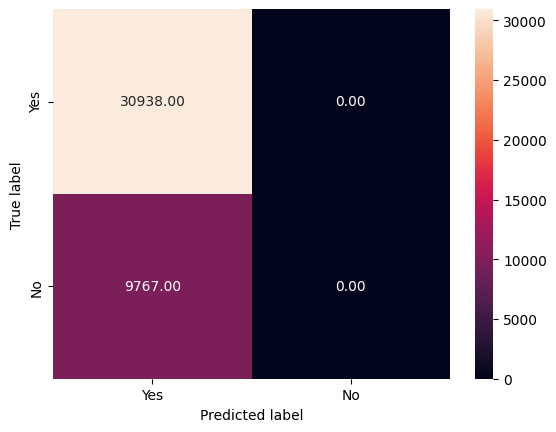


Training Data
              precision    recall  f1-score   support

           0       0.76      1.00      0.86     30938
           1       0.00      0.00      0.00      9767

    accuracy                           0.76     40705
   macro avg       0.38      0.50      0.43     40705
weighted avg       0.58      0.76      0.66     40705



C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

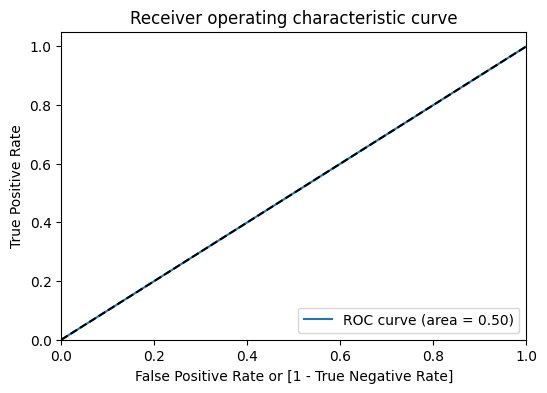


Test  Data
[[7735    0]
 [2442    0]]


C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


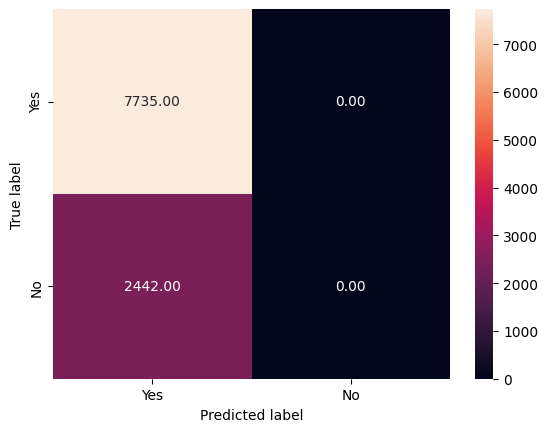


Test  Data
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      7735
           1       0.00      0.00      0.00      2442

    accuracy                           0.76     10177
   macro avg       0.38      0.50      0.43     10177
weighted avg       0.58      0.76      0.66     10177



C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

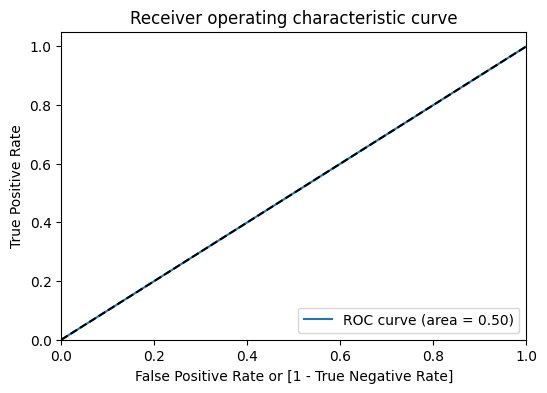

i = 1 Model = KNN
Model parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}

Training Data
[[30938     0]
 [    0  9767]]


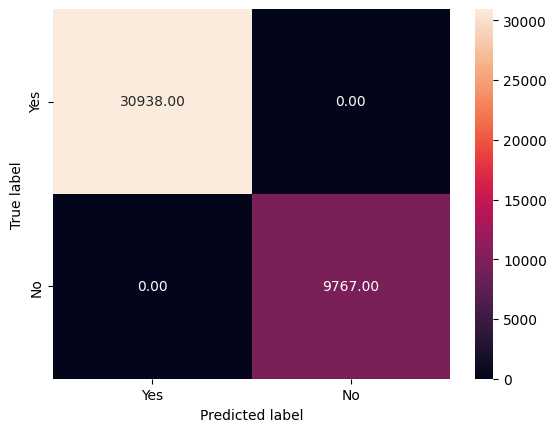


Training Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30938
           1       1.00      1.00      1.00      9767

    accuracy                           1.00     40705
   macro avg       1.00      1.00      1.00     40705
weighted avg       1.00      1.00      1.00     40705



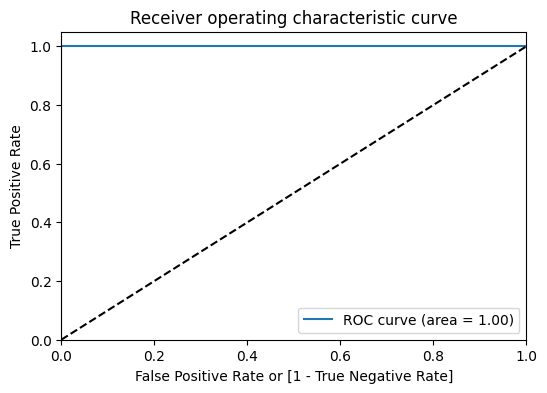


Test  Data
[[6374 1361]
 [2036  406]]


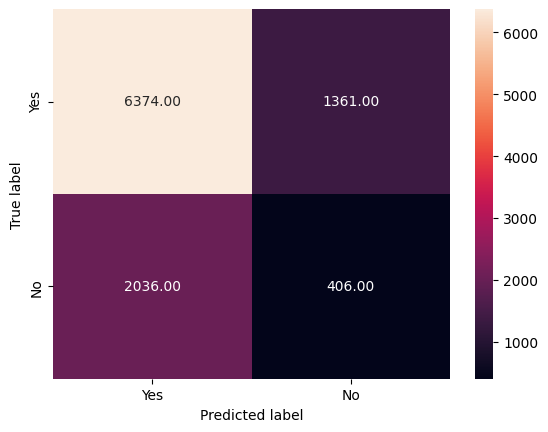


Test  Data
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      7735
           1       0.23      0.17      0.19      2442

    accuracy                           0.67     10177
   macro avg       0.49      0.50      0.49     10177
weighted avg       0.63      0.67      0.65     10177



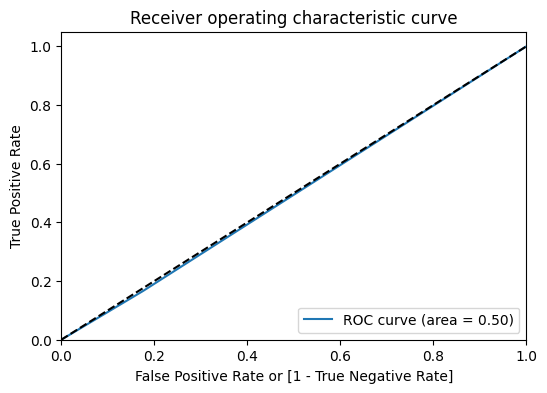

i = 2 Model = CART
Model parameters: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}

Training Data
[[ 4353 26585]
 [  420  9347]]


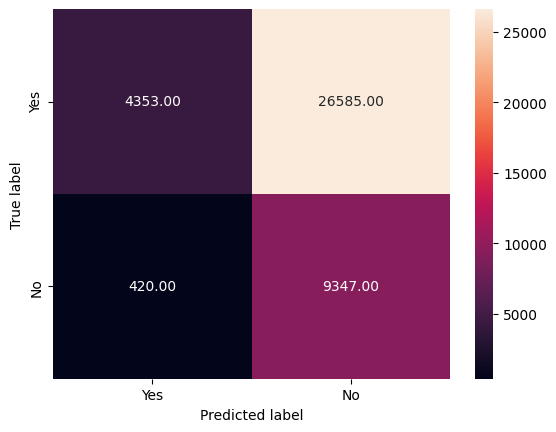


Training Data
              precision    recall  f1-score   support

           0       0.91      0.14      0.24     30938
           1       0.26      0.96      0.41      9767

    accuracy                           0.34     40705
   macro avg       0.59      0.55      0.33     40705
weighted avg       0.76      0.34      0.28     40705



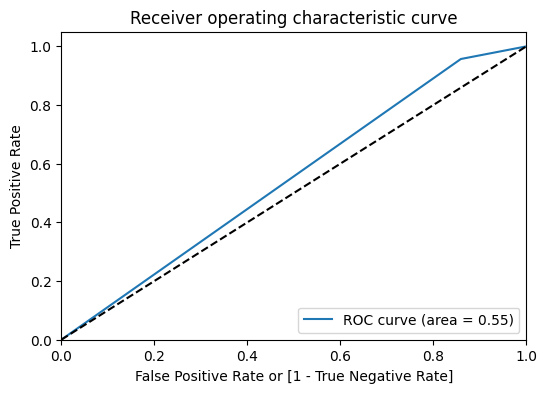


Test  Data
[[1063 6672]
 [ 122 2320]]


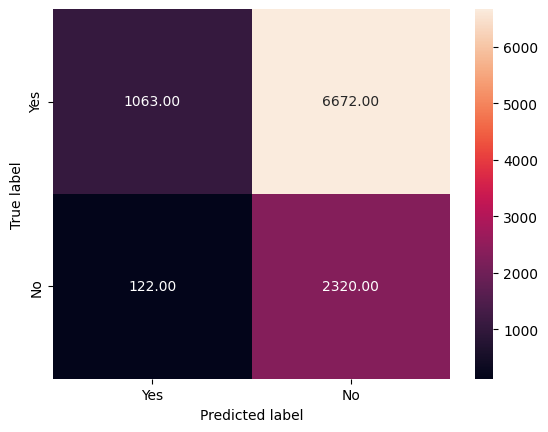


Test  Data
              precision    recall  f1-score   support

           0       0.90      0.14      0.24      7735
           1       0.26      0.95      0.41      2442

    accuracy                           0.33     10177
   macro avg       0.58      0.54      0.32     10177
weighted avg       0.74      0.33      0.28     10177



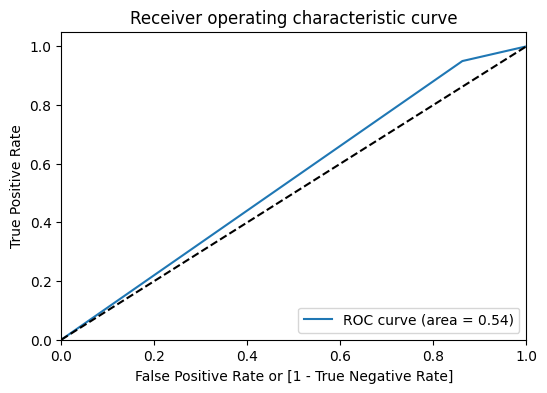

i = 3 Model = NB
Model parameters: {'priors': None, 'var_smoothing': 0.001}

Training Data
[[30938     0]
 [ 9767     0]]


C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


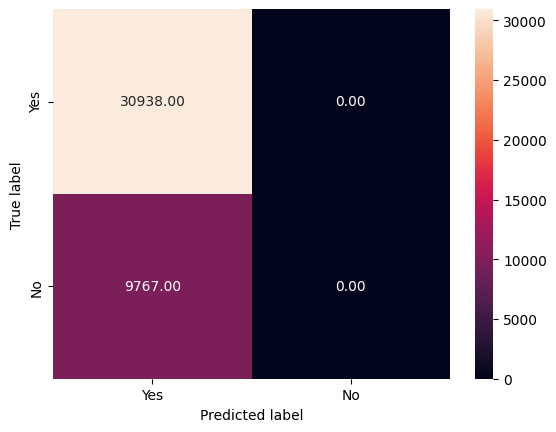

C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r


Training Data
              precision    recall  f1-score   support

           0       0.76      1.00      0.86     30938
           1       0.00      0.00      0.00      9767

    accuracy                           0.76     40705
   macro avg       0.38      0.50      0.43     40705
weighted avg       0.58      0.76      0.66     40705



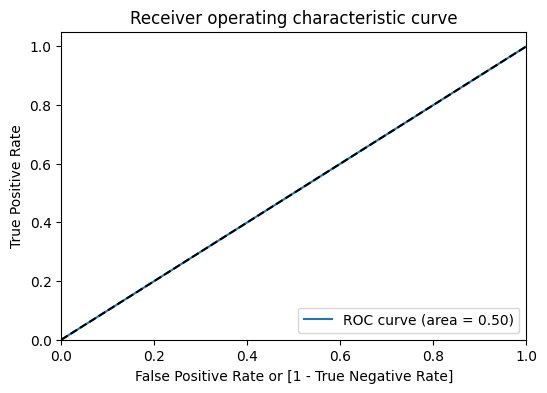


Test  Data
[[7735    0]
 [2442    0]]


C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


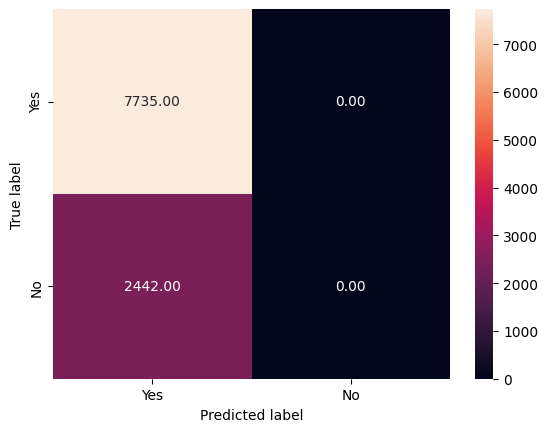

C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r


Test  Data
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      7735
           1       0.00      0.00      0.00      2442

    accuracy                           0.76     10177
   macro avg       0.38      0.50      0.43     10177
weighted avg       0.58      0.76      0.66     10177



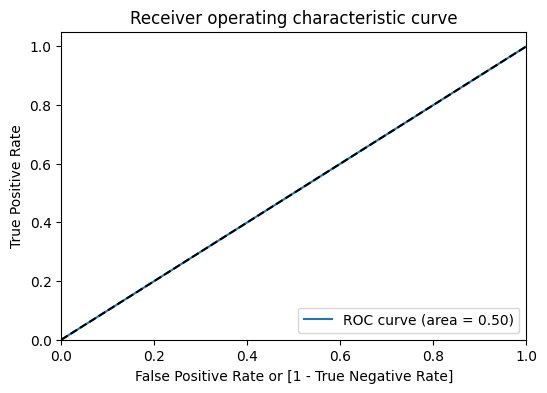

i = 4 Model = RF
Model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Training Data
[[ 6661 24277]
 [  809  8958]]


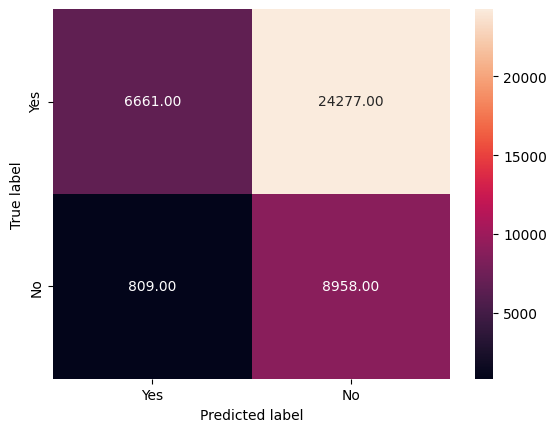


Training Data
              precision    recall  f1-score   support

           0       0.89      0.22      0.35     30938
           1       0.27      0.92      0.42      9767

    accuracy                           0.38     40705
   macro avg       0.58      0.57      0.38     40705
weighted avg       0.74      0.38      0.36     40705



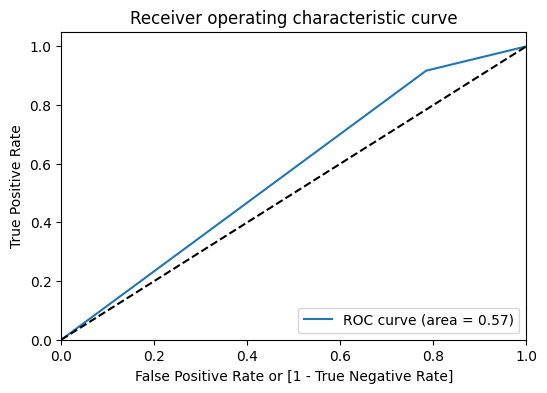


Test  Data
[[1607 6128]
 [ 257 2185]]


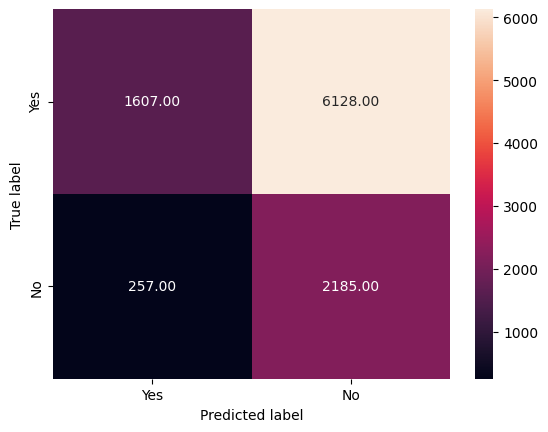


Test  Data
              precision    recall  f1-score   support

           0       0.86      0.21      0.33      7735
           1       0.26      0.89      0.41      2442

    accuracy                           0.37     10177
   macro avg       0.56      0.55      0.37     10177
weighted avg       0.72      0.37      0.35     10177



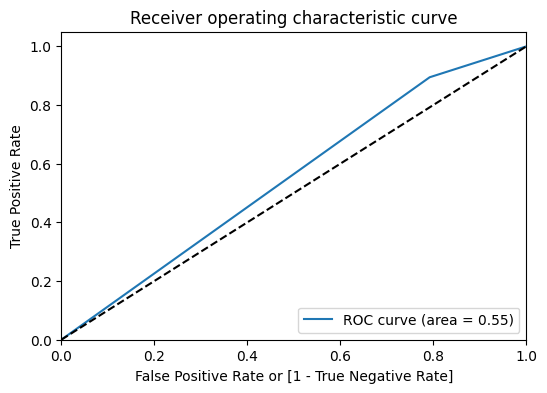

i = 5 Model = XGBoost
Model parameters: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 10, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}

Training Data
[[30905    33]
 [ 1870  7897]]


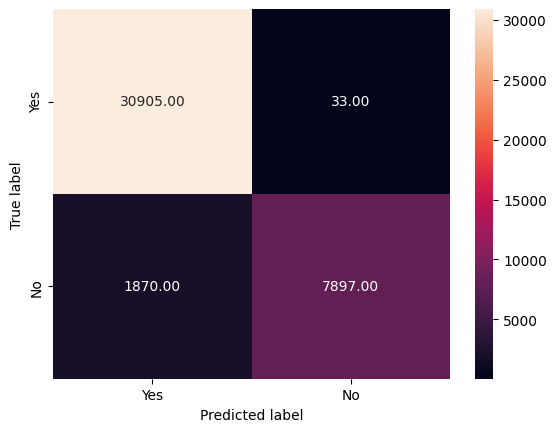


Training Data
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     30938
           1       1.00      0.81      0.89      9767

    accuracy                           0.95     40705
   macro avg       0.97      0.90      0.93     40705
weighted avg       0.96      0.95      0.95     40705



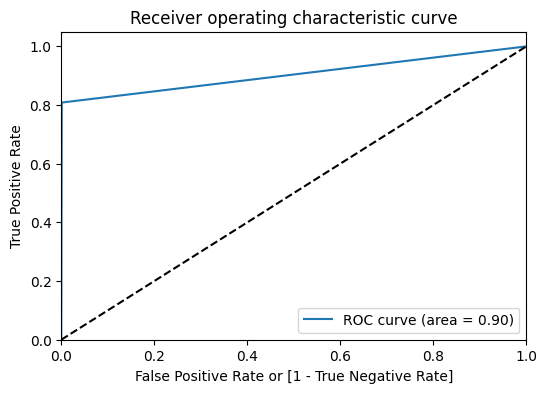


Test  Data
[[7237  498]
 [2093  349]]


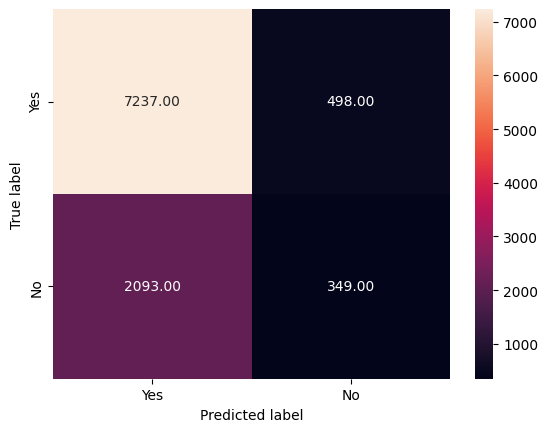


Test  Data
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      7735
           1       0.41      0.14      0.21      2442

    accuracy                           0.75     10177
   macro avg       0.59      0.54      0.53     10177
weighted avg       0.69      0.75      0.70     10177



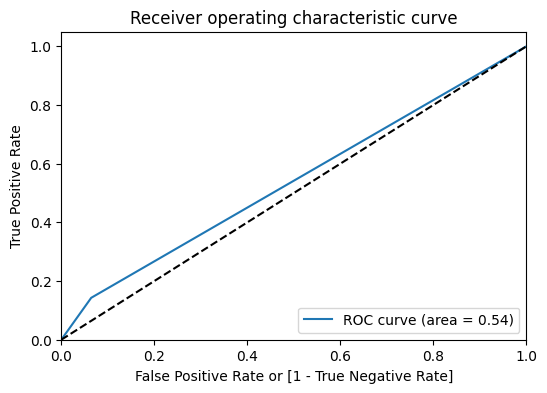

i = 6 Model = AdaBoost
Model parameters: {'algorithm': 'SAMME', 'estimator': None, 'learning_rate': 0.1, 'n_estimators': 300, 'random_state': None}

Training Data
[[30938     0]
 [ 9767     0]]


C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


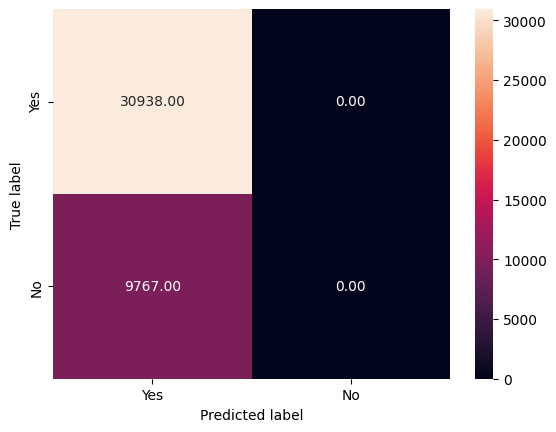

C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Data
              precision    recall  f1-score   support

           0       0.76      1.00      0.86     30938
           1       0.00      0.00      0.00      9767

    accuracy                           0.76     40705
   macro avg       0.38      0.50      0.43     40705
weighted avg       0.58      0.76      0.66     40705



C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


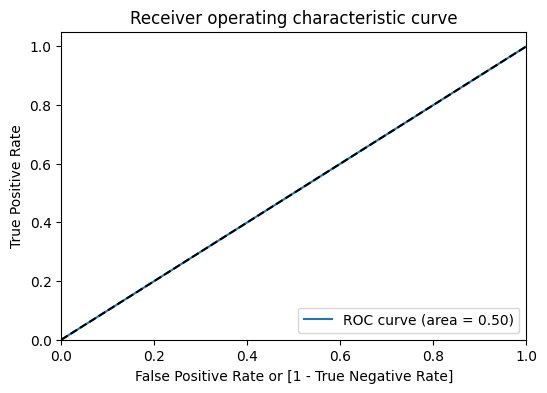


Test  Data
[[7735    0]
 [2442    0]]


C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


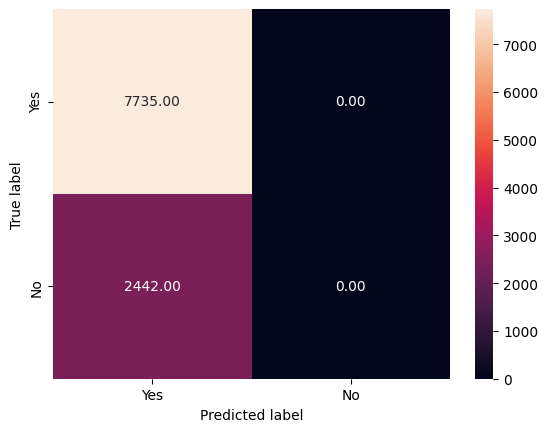

C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAI SWAROOP\anaconda3\Anacondas\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r


Test  Data
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      7735
           1       0.00      0.00      0.00      2442

    accuracy                           0.76     10177
   macro avg       0.38      0.50      0.43     10177
weighted avg       0.58      0.76      0.66     10177



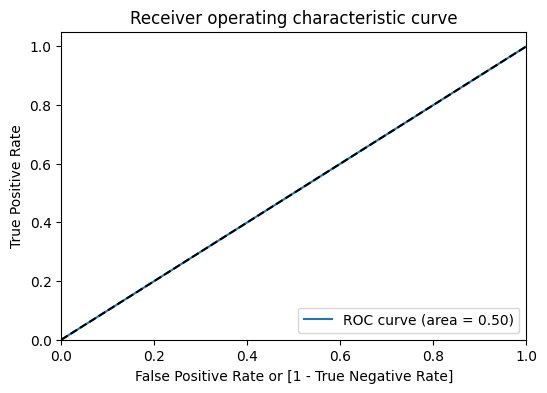

In [130]:
models       =  [LogisticRegression(C =  0.0006951927961775605, intercept_scaling =  3, penalty = None, solver = 'saga'),\
                 KNeighborsClassifier(n_neighbors = 3,  weights = 'distance'),\
                 DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy',\
                                        max_depth = 3, min_samples_leaf = 10,\
                                       min_samples_split = 5 ),
                 GaussianNB(var_smoothing = 0.001),\
                 RandomForestClassifier(class_weight = 'balanced',max_depth = 4, n_estimators= 50),\
                 XGBClassifier(max_depth = 10),\
                 AdaBoostClassifier(algorithm = 'SAMME',learning_rate = 0.1, n_estimators = 300)]
SMOTE_metrics_df =  pd.DataFrame()
for   i    in   range(len(model_names)):
      model_x            =   model_names[i]
      print("i = %d Model = %s" %(i,model_x))
      classifier         =   models[i] 
      smote_df = evaluate_model_SM_performance(model_x, classifier, file_X_train_SMOTE, file_y_train_SMOTE, X_test, y_test)
      SMOTE_metrics_df =  pd.concat([SMOTE_metrics_df,smote_df])

In [131]:
SMOTE_metrics_df.sort_values(by=['Recall Test data'], ascending = False)

,Model,Recall Training data,Recall Test data,F1 Weighted Training data,F1 Weighted Test data,AUROC Training data,AUROC Test data,Precision Training data,Precision Test data
0,CART,0.956998,0.950041,0.283448,0.278525,0.548849,0.543734,0.260130,0.258007
0,RF,0.917170,0.894758,0.363598,0.351982,0.566236,0.551258,0.269535,0.262841
0,KNN,1.000000,0.166257,1.000000,0.646421,1.000000,0.495152,1.000000,0.229768
0,XGBoost,0.808539,0.142916,0.951497,0.695572,0.903736,0.539266,0.995839,0.412043
0,LR,0.000000,0.000000,0.656437,0.656428,0.500000,0.500000,0.000000,0.000000
0,NB,0.000000,0.000000,0.656437,0.656428,0.500000,0.500000,0.000000,0.000000
0,AdaBoost,0.000000,0.000000,0.656437,0.656428,0.500000,0.500000,0.000000,0.000000


In [ ]:
import sklearn.metrics   as   metrics

In [ ]:
clf1    =   DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy',\
                                        max_depth = 3, min_samples_leaf = 10,\
                                       min_samples_split = 5)
clf1.fit(file_X_train_SMOTE, file_y_train_SMOTE)
#Predict the response for train dataset
predicted_train = clf1.predict(file_X_train_SMOTE)

In [ ]:
feature_names  =  file_X_train_SMOTE.columns

# Variable Importance Plot

In [ ]:
varImp_df   = pd.DataFrame({'Feature_names' :feature_names,\
                            'Importances' : clf1.feature_importances_})
varImp_df.sort_values('Importances', ascending = False) 

In [ ]:
importances = clf1.feature_importances_
indices     = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()